# Survival Analysis - zscores

author: emile esmaili

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.facecolor'] = 'white'
warnings.filterwarnings("ignore")

from sksurv.preprocessing import OneHotEncoder

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.linear_model import LassoCV
import xgboost as xgb
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from umap import UMAP

import shap
from Bio import Entrez
import re
from IPython.display import display, Markdown, Latex

## Cleaning, Preprocessing

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")

In [3]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [5]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()


If there is NA values: True


In [6]:
# thus, we need to drop all of same_value_cols: 
df_clean = df_clean.drop(same_value_cols, axis = 1)
df_clean = df_clean.dropna(axis=1)


In [7]:
gene_table = pd.read_table('supplement_data/gene_table.tsv')


In [8]:
# Set the NCBI GeneID column as the index of the mapping dataframe
mapping_df = gene_table.set_index('NCBI GeneID')
# Create a dictionary that maps NCBI GeneIDs to Symbols
id_to_symbol = mapping_df['Symbol'].to_dict()
# Rename the columns of the original dataframe using the dictionary
df_clean = df_clean.rename(columns=id_to_symbol)
df_clean = df_clean.add_prefix('gene_')
# convert column names to string
df_clean.columns = df_clean.columns.astype(str)

In [9]:
adata= sc.AnnData(df_clean)

normalizing counts per cell
    finished (0:00:00)


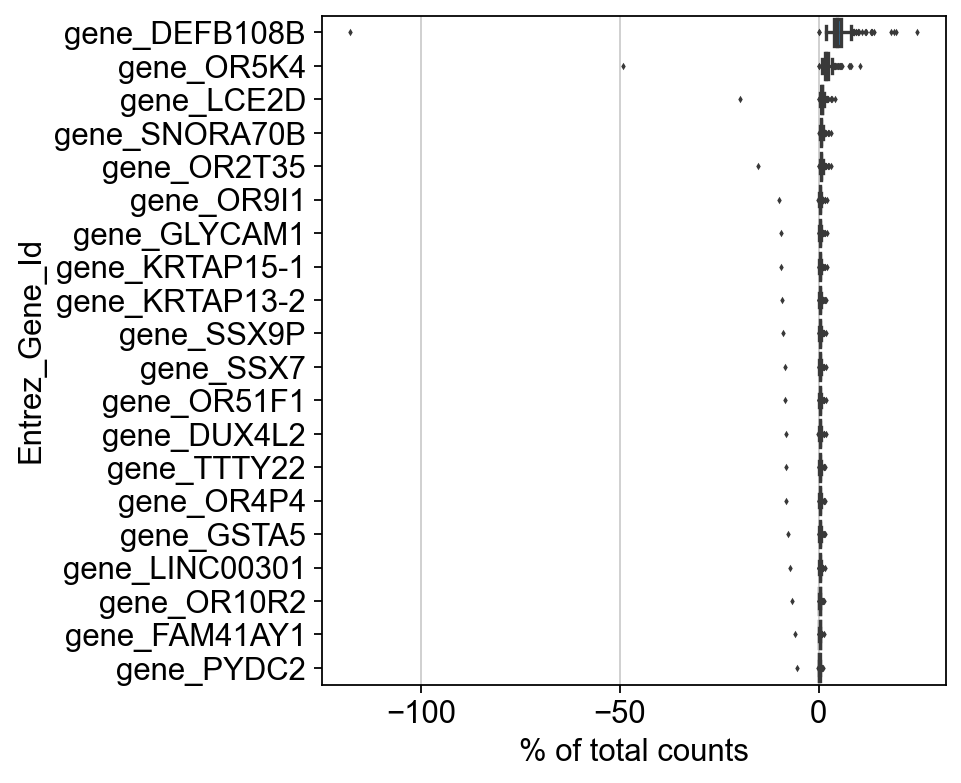

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

Clustering

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


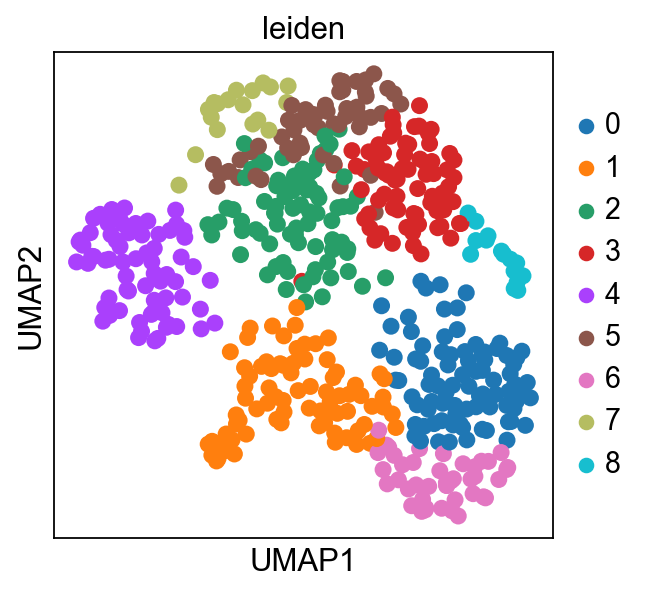

In [11]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [12]:
print("Explained variance of PCA:" , adata.uns['pca']['variance_ratio'].sum())

Explained variance of PCA: 0.7036328


In [13]:
clusters_df = pd.DataFrame(adata.obs['leiden']).reset_index(level=0)
clusters_df['index'] = clusters_df['index'].str[:-3]

Clinical Patient Data

In [14]:
data_patient = pd.read_table('data/data_clinical_patient.txt', sep='\t')
print(data_patient.iloc[0])


#Patient Identifier                                                                                   #Identifier to uniquely specify a patient.
Subtype                                                                                                                                  Subtype
TCGA PanCanAtlas Cancer Type Acronym                                                           Text field to hold cancer type acronym used by...
Other Patient ID                                                                                         Legacy DMP patient identifier (DMPnnnn)
Diagnosis Age                                                                                  Age at which a condition or disease was first ...
Sex                                                                                                                                          Sex
Neoplasm Disease Stage American Joint Committee on Cancer Code                                 The extent of a cancer, especially 

In [15]:
data_patient = data_patient.drop([0,1,2,3], axis = 0)
df_patient = data_patient.reset_index(drop=True)

In [16]:
df_patient.head(3)

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Patient Weight,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months)
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,NaN,Yes,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,NaN,Yes,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,NaN,Yes,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082


Adding statistical clusters to patient data

In [17]:
df_patient_clusters = pd.merge(left=df_patient, right=clusters_df, left_on='#Patient Identifier', right_on="index")

In [18]:
droper = ['Other Patient ID',  'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date','Form completion date',
       'Informed consent verified','Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',  
        'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Tumor Stage Code',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Disease Free Status', "Patient Weight",
       'Disease Free (Months)', 'Ethnicity Category','Primary Lymph Node Presentation Assessment',
       'index','Progress Free Survival (Months)', 'Months of disease-specific survival',
        'Disease-specific Survival status', 'Progression Free Status'

       ]

In [19]:
df_patient_clusters = df_patient_clusters.drop(droper, axis=1).reset_index(drop=True)

Adding genes to patient data

In [20]:
df_clean['ID'] = df_clean.index
df_clean['ID'] = df_clean['ID'].str[:-3]



In [21]:
binary_columns = ['Overall Survival Status']
for col in binary_columns:
    df_patient_clusters[col] = pd.to_numeric(df_patient_clusters[col].str[0])

Encoding

In [22]:
df_patient_clusters['Person Neoplasm Cancer Status'] = df_patient_clusters['Person Neoplasm Cancer Status'].map({'With Tumor': 1, 'Tumor Free': 0})
df_patient_clusters['Prior Diagnosis'] = df_patient_clusters['Prior Diagnosis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Radiation Therapy'] = df_patient_clusters['Radiation Therapy'].map({'Yes': 1, 'No': 0})
df_patient_clusters['In PanCan Pathway Analysis'] = df_patient_clusters['In PanCan Pathway Analysis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Sex'] = df_patient_clusters['Sex'].map({'Male': 1, 'Female': 0})

In [23]:
# perform one-hot encoding 
cat_data = ['Race Category','Subtype']
df_patient_clusters_enc = df_patient_clusters
for feature in cat_data:
    encoded_df = pd.get_dummies(df_patient_clusters_enc[feature])
    # cncatenate the original dataframe with the encoded dataframe
    df_patient_clusters_enc = pd.concat([df_patient_clusters_enc, encoded_df], axis=1)
    # drop the original categorical column
df_patient_clusters_enc.drop(cat_data, axis=1, inplace=True)

In [24]:
df_genes = df_clean
df_genes['ID'] = df_genes.index.str[:-3]
df_genes = df_genes.reset_index(drop=True)

In [25]:
#df_patient_clusters_enc = df_patient_clusters_enc.dropna()

In [26]:
df_patient_clusters_enc['Overall Survival Status'] = df_patient_clusters_enc['Overall Survival Status'].fillna(df_patient_clusters_enc['Overall Survival Status'].mode()[0])
df_patient_clusters_enc['Overall Survival (Months)'] = df_patient_clusters_enc['Overall Survival (Months)'].fillna(df_patient_clusters_enc['Overall Survival (Months)'].median())
df_patient_clusters_enc['Sex'] = df_patient_clusters_enc['Sex'].fillna(df_patient_clusters_enc['Sex'].mode()[0])

Feature selection with mutual info

In [27]:
from sklearn.feature_selection import mutual_info_regression
# create a dataframe containing mutual information for each feature
var = ['Overall Survival (Months)', 'Overall Survival Status']
midf = pd.DataFrame({
    "feature": df_genes.drop('ID', axis=1).columns.values,
    "mi": mutual_info_regression(df_genes.drop('ID', axis=1).values, df_patient_clusters_enc[var[0]].astype(float).values, random_state=42),
}).sort_values("mi", ascending=False)

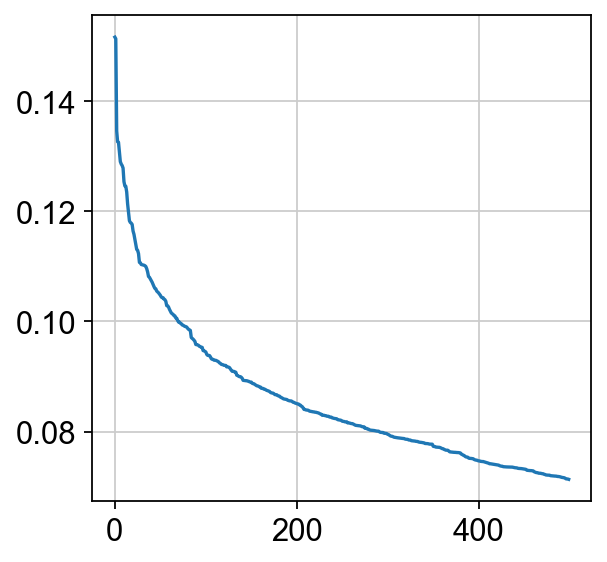

In [28]:
plt.plot(np.arange(500), midf.mi.iloc[:500])

In [29]:
selected_genes = midf.loc[midf.mi >= 0.08, "feature"]
len(selected_genes)

291

In [30]:
df_genes_select = df_genes[list(selected_genes)+['ID']]

In [31]:
df_ML = pd.merge(df_patient_clusters_enc, df_genes_select, left_on='#Patient Identifier', right_on='ID').drop('ID', axis=1)
df_ML= df_ML.loc[:, ~df_ML.columns.duplicated()].drop('#Patient Identifier', axis=1)


 Preprocessing

In [32]:
def preproc(X):
    categorical = ['Sex','Person Neoplasm Cancer Status', 'Prior Diagnosis',
                            'Radiation Therapy','In PanCan Pathway Analysis', 'American Indian or Alaska Native','White',
                            'Asian','Black or African American','LGG_IDHmut-codel','LGG_IDHmut-non-codel','LGG_IDHwt',
                            'Overall Survival Status',
                            ]

    categorical_features = list(set(categorical) & set(X.columns))
    numeric_features = X.drop(categorical_features, axis=1,errors='raise')
    numeric_features = numeric_features.columns.tolist()


    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
        ])

    #Replacing missing values with Modal value and then one hot encoding.
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ])

    preprocessor = ColumnTransformer(transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
                ])
    return preprocessor.fit_transform(X)


In [33]:
var = ['Overall Survival (Months)', 'Overall Survival Status']
X = df_ML.drop(var, axis=1).reset_index(drop=True)


## 🏆 Survival Models

In [34]:
y_surv = pd.concat([df_ML['Overall Survival Status'].astype(bool), df_ML['Overall Survival (Months)'].apply(pd.to_numeric)], axis=1).to_records(index=False)
X_surv = preproc(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_surv, y_surv, random_state=42)

### RF and Boosting 

In [36]:
random_state = 666

In [37]:
booster = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state
)
booster.fit(X_train, y_train)


GradientBoostingSurvivalAnalysis(learning_rate=1, max_depth=1, random_state=666)

In [38]:
print("Train score: {:.3f}".format(booster.score(X_train, y_train)), "\nTest score: {:.3f}".format(booster.score(X_test, y_test)))

Train score: 0.971 
Test score: 0.818


In [39]:
rf = RandomSurvivalForest(n_estimators=50,
                           #min_samples_split=10,
                           #min_samples_leaf=10,
                           n_jobs=-1,
                           random_state=random_state)
rf.fit(X_train, y_train)


RandomSurvivalForest(n_estimators=50, n_jobs=-1, random_state=666)

In [40]:
print("Train score: {:.3f}".format(rf.score(X_train, y_train)), "\nTest score: {:.3f}".format(rf.score(X_test, y_test)))

Train score: 0.956 
Test score: 0.811


### Elastic Net Cox Model

In [41]:
cox_net = CoxnetSurvivalAnalysis(l1_ratio= 0.9,
                                  alpha_min_ratio= 0.25,
                                    fit_baseline_model=True)
cox_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [42]:
cv=True
cv2=False

In [43]:
if cv==True:
    cox_elastic_net = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    params = {'l1_ratio':np.arange(0.1,1.05,0.05), "alpha_min_ratio":np.arange(0.1,1.05,0.05)}
    cox_net_cv = GridSearchCV(cox_elastic_net,
                        param_grid=params,
                        n_jobs=-1,
                        cv=5,
                        )
    cox_net_cv.fit(X_train, y_train)
    #extract best score and parameter by calling objects "best_score_" and "best_params_"
    print("best mean cross-validation score: {:.3f}".format(cox_net_cv.best_score_))
    print("best parameters: {}".format(cox_net_cv.best_params_))
    print("Train score: {:.3f}".format(cox_net_cv.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net_cv.score(X_test, y_test)))
    cox_net = cox_net_cv.best_estimator_

best mean cross-validation score: 0.840
best parameters: {'alpha_min_ratio': 0.1, 'l1_ratio': 0.1}
Train score: 0.902 
Test score: 0.884


In [44]:
if cv2==True:
    estimated_alphas = cox_net.alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.25, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=-1)
    gcv.fit(X_train, y_train)
    cox_net = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

In [45]:
print("Train score: {:.3f}".format(cox_net.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net.score(X_test, y_test)))

Train score: 0.902 
Test score: 0.884


## Feature Importance

In [47]:
gene_numbers = [col.split('_')[1] for col in X.columns if col.startswith('gene_')]
gene_numbers = pd.DataFrame(gene_numbers, columns=['ID'])


In [48]:
def plot_coef(model,labels,k=15,proj=None, return_results=False, plot=True):

    if proj==None:
        coef = model.coef_
    else:
        coef_proj  =  model.coef_[:,-1].reshape(-1,1)
        coef = proj.inverse_transform(coef_proj.T).T
        
    best_coefs = pd.DataFrame(
        coef[:,-1],
        index=labels,
        columns=["coefficient"]
    )
    non_zero = np.sum(best_coefs.iloc[:, 0] != 0)

    non_zero_coefs = best_coefs.query("coefficient != 0")
    coef_order = non_zero_coefs.abs().sort_values("coefficient").index
    alpha = round(model.alphas_[-1],2)
    top_features = non_zero_coefs.loc[coef_order]['coefficient'].tail(k)
    if plot==True:
        print("Number of non-zero coefficients: {}".format(non_zero))
        _, ax = plt.subplots(figsize=(6, 6))
        top_features.plot.barh(ax=ax, legend=False)
        ax.set_xlabel("coefficient")
        ax.set_title(f'Top {k} features (z-score data), $\\alpha={alpha} $')
        ax.grid(True)
    if return_results ==True:
        return top_features, top_features.index

Number of non-zero coefficients: 94


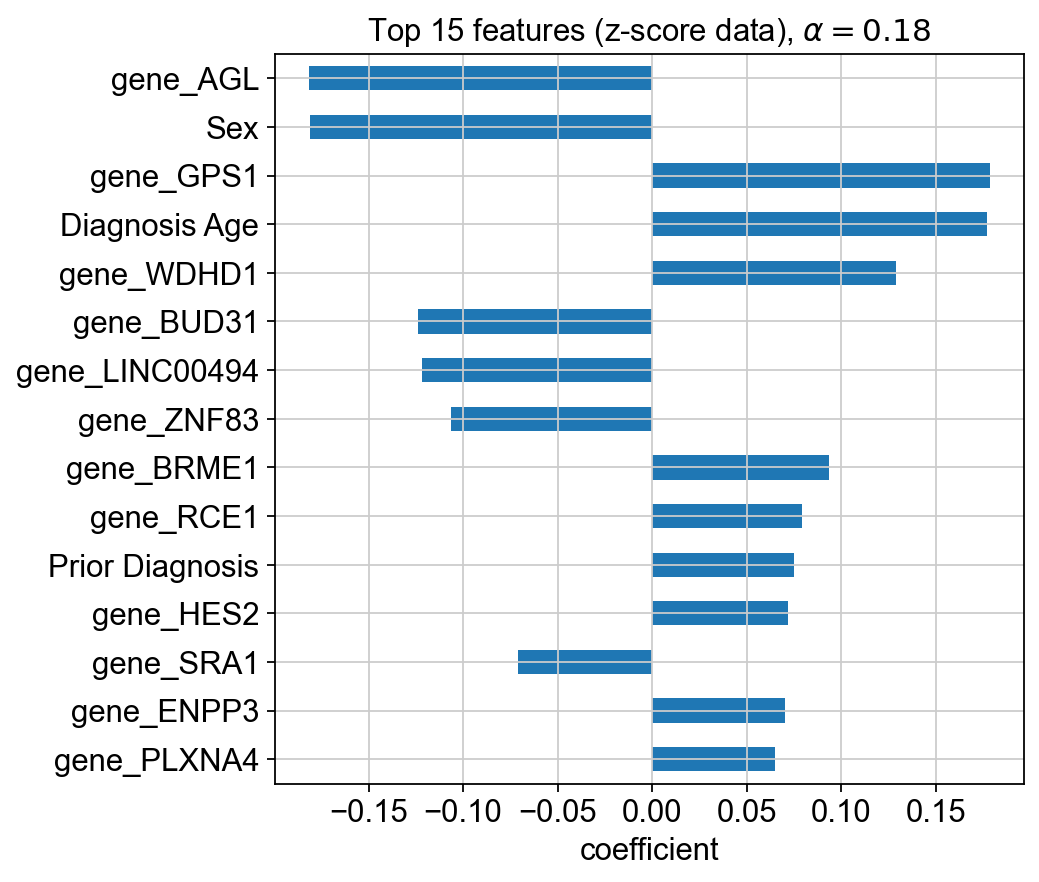

In [49]:
plot_coef(cox_net, X.columns)

## Survival Curves

Text(0.5, 0, 'time $t$')

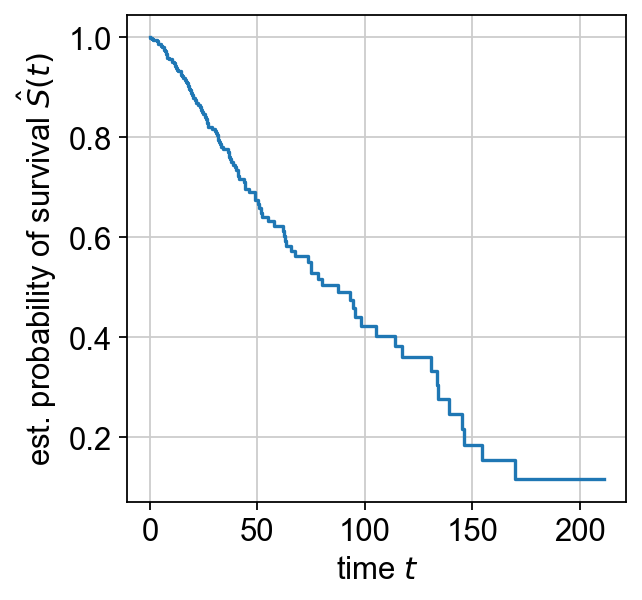

In [50]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(df_ML["Overall Survival Status"].astype(bool), df_ML['Overall Survival (Months)'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [51]:
def df_from_rec(y_surv_df):
    # Convert y_surv back to a DataFrame
    y_surv_df = pd.DataFrame(y_surv_df, columns=['Overall Survival Status', 'Overall Survival (Months)'])

    # Separate the columns into two DataFrames
    df_ML_recovered = pd.DataFrame(y_surv_df['Overall Survival Status'])
    df_ML_recovered['Overall Survival (Months)'] = y_surv_df['Overall Survival (Months)']

    return df_ML_recovered['Overall Survival Status'], df_ML_recovered['Overall Survival (Months)']

In [52]:
def plot_surv_curves(X_train, y_train, X_test, y_test, model):

    survival_function_test = model.predict_survival_function(X_test, return_array=False)
    survival_function_train = model.predict_survival_function(X_train, return_array=False)
    score_test = model.score(X_test, y_test)
    score_train = model.score(X_train, y_train)

    fig, ax = plt.subplots(1,2, figsize=(10,4))

    for i, (a, b) in enumerate(y_train):
        ax[0].plot(survival_function_train[i].x, survival_function_train[i].y, alpha=0.05, c='blue')
    for i, (a, b) in enumerate(y_test):
        ax[1].plot(survival_function_test[i].x, survival_function_test[i].y, alpha=0.05, c='blue')

    y_hat_train = np.array([s.y for s in survival_function_train])  # Extract y values from step functions
    avg_survival_train = np.mean(y_hat_train, axis=0) 

    y_hat_test = np.array([s.y for s in survival_function_test])  # Extract y values from step functions
    avg_survival_test = np.mean(y_hat_train, axis=0) 

    ax[0].plot(survival_function_train[0].x, avg_survival_train, alpha=1, c='red', label='model average')
    ax[1].plot(survival_function_test[0].x, avg_survival_test, alpha=1, c='red', label='model average')

    # KM
    status_train, time_train = df_from_rec(y_train)
    time_cell, survival_prob_cell = kaplan_meier_estimator(status_train.astype(bool),
                                                            time_train)        
    ax[0].plot(time_cell, survival_prob_cell,
                   label='Kaplan Meier', c='black'
                   )
    
    status_test, time_test = df_from_rec(y_test)
    time_cell, survival_prob_cell = kaplan_meier_estimator(status_test.astype(bool),
                                                            time_test)        
    ax[1].plot(time_cell, survival_prob_cell,
                   label='Kaplan Meier', c='black'
                   )

    fig.supxlabel('Time')
    fig.supylabel('Survival probability')

    ax[0].set_title(f'Train Predicted Survival Curves (Score={score_train:.3f})')
    ax[1].set_title(f'Test Predicted Survival Curves (Score={score_test:.3f})')
    plt.legend()
    plt.show()


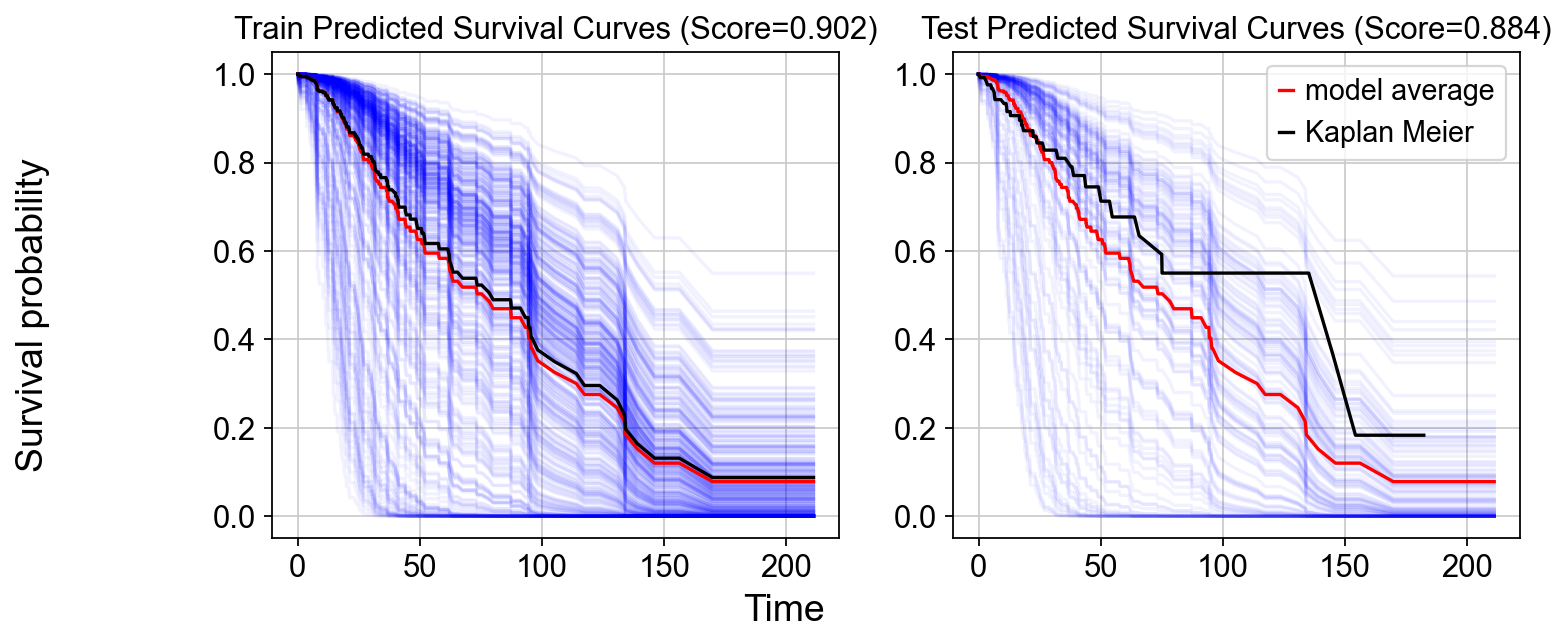

In [53]:
plot_surv_curves(X_train, y_train, X_test, y_test, cox_net)

## Exploration:  PCA Elastic Net Model 

In [54]:
n=50

pca_train = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)
pca_test = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)

X_train_pca = pca_train.fit_transform(X_train)
X_test_pca = pca_test.fit_transform(X_test)
y_train_pca = y_train
y_test_pca = y_test


In [55]:
n = 50
pca = KernelPCA(n_components=n,
                 kernel='rbf',
                 degree=5,
                 #gamma=1e-7,
                 fit_inverse_transform=True)
umap = UMAP()
tsne = TSNE()
proj = pca
X_pca = proj.fit_transform(X_surv)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_surv, random_state=42)

In [56]:
cox_net2 = CoxnetSurvivalAnalysis(l1_ratio= 0.9,
                                  alpha_min_ratio= 0.25,
                                    fit_baseline_model=True)
cox_net2.fit(X_train_pca, y_train_pca)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [57]:

print("Train score: {:.3f}".format(cox_net2.score(X_train_pca, y_train_pca)), "\nTest score: {:.3f}".format(cox_net2.score(X_test_pca, y_test_pca)))


Train score: 0.786 
Test score: 0.795


Survival curves

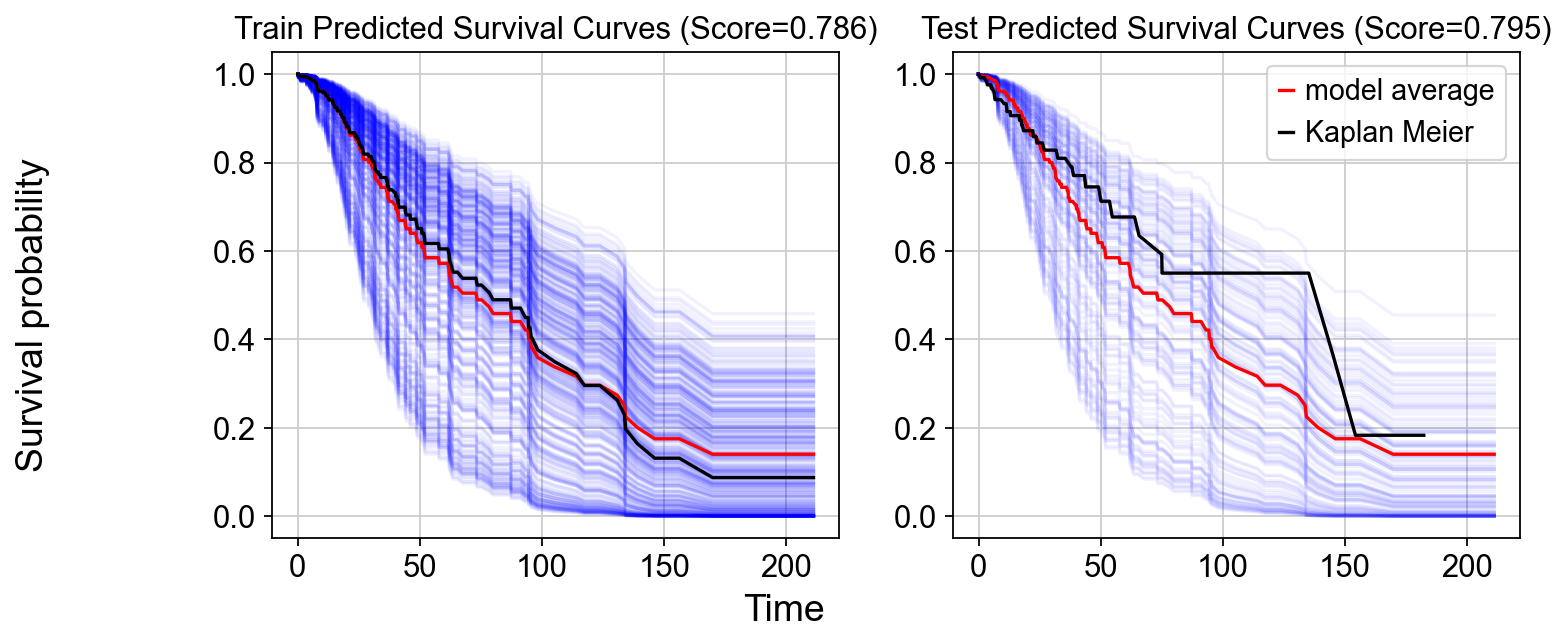

In [58]:
plot_surv_curves(X_train_pca, y_train_pca, X_test_pca, y_test_pca, cox_net2)

 Interpretation

Number of non-zero coefficients: 306


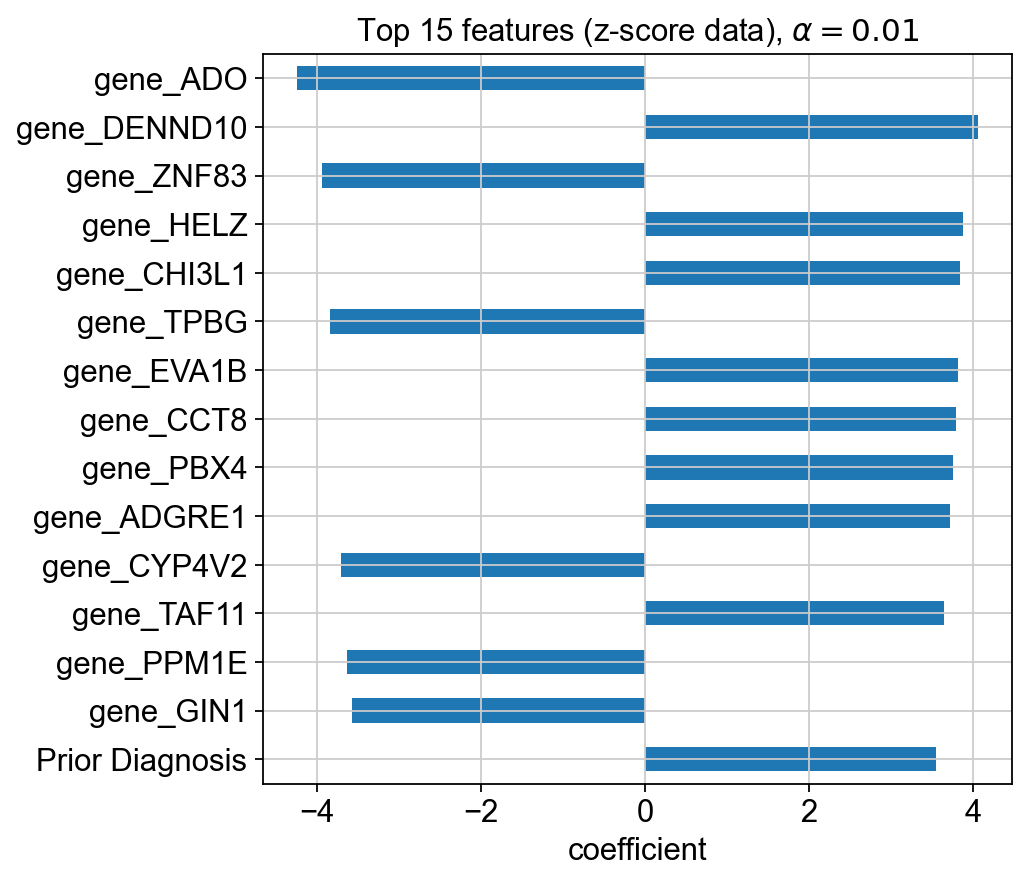

In [59]:
plot_coef(cox_net2, X.columns, proj=proj)

**Results are not good**

- The lead features are very different
- the choice of kernel matters a lot: RBF has good performance but shrinks to the mean, prefer polynomial
- This model seems very unstable
- the LASSO shrinkage does not happen

## Look at grouping patients

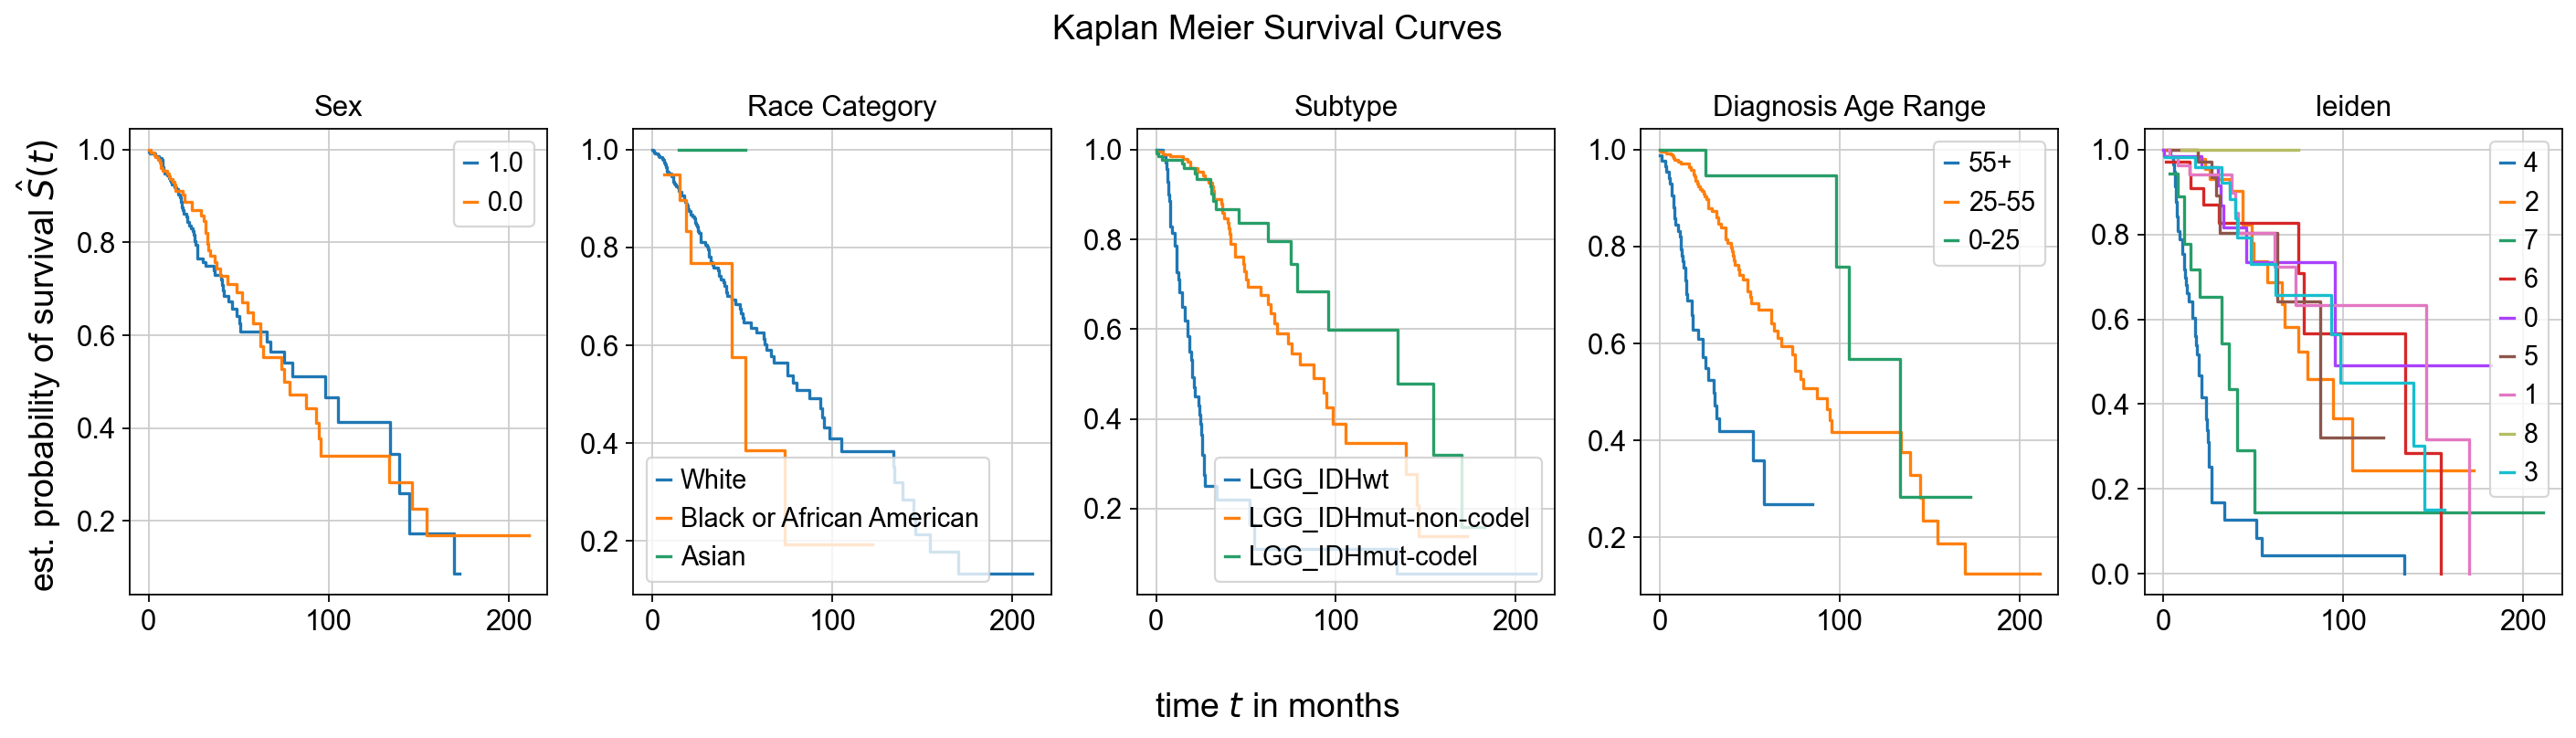

In [60]:
df = df_patient_clusters.dropna(axis=0).copy()

# define the age ranges and corresponding labels
age_ranges = [0, 25, 55, str('inf')]
age_labels = ['0-25', '25-55', '55+']
# use cut() function to create a new column with age ranges
df['Diagnosis Age Range'] = pd.cut(df['Diagnosis Age'], bins=age_ranges, labels=age_labels, include_lowest=True)

vars = ['Sex', 'Race Category', 'Subtype', 'Diagnosis Age Range', 'leiden']
n = len(vars)
fig, ax = plt.subplots(1,n, figsize=(18,5))
for i in range(n):
    var = vars[i]
    for value in df[var].unique():
        mask = df[var] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(df["Overall Survival Status"].astype(bool)[mask],
                                                            df["Overall Survival (Months)"][mask])        
        ax[i].step(time_cell, survival_prob_cell, where="post",
                   label=value)
        ax[i].set_title(f'{var}')
        ax[i].legend(loc="best")

fig.supylabel("est. probability of survival $\hat{S}(t)$")
fig.supxlabel("time $t$ in months")
fig.suptitle('Kaplan Meier Survival Curves')
plt.tight_layout()


Curves for Sex: 0.0


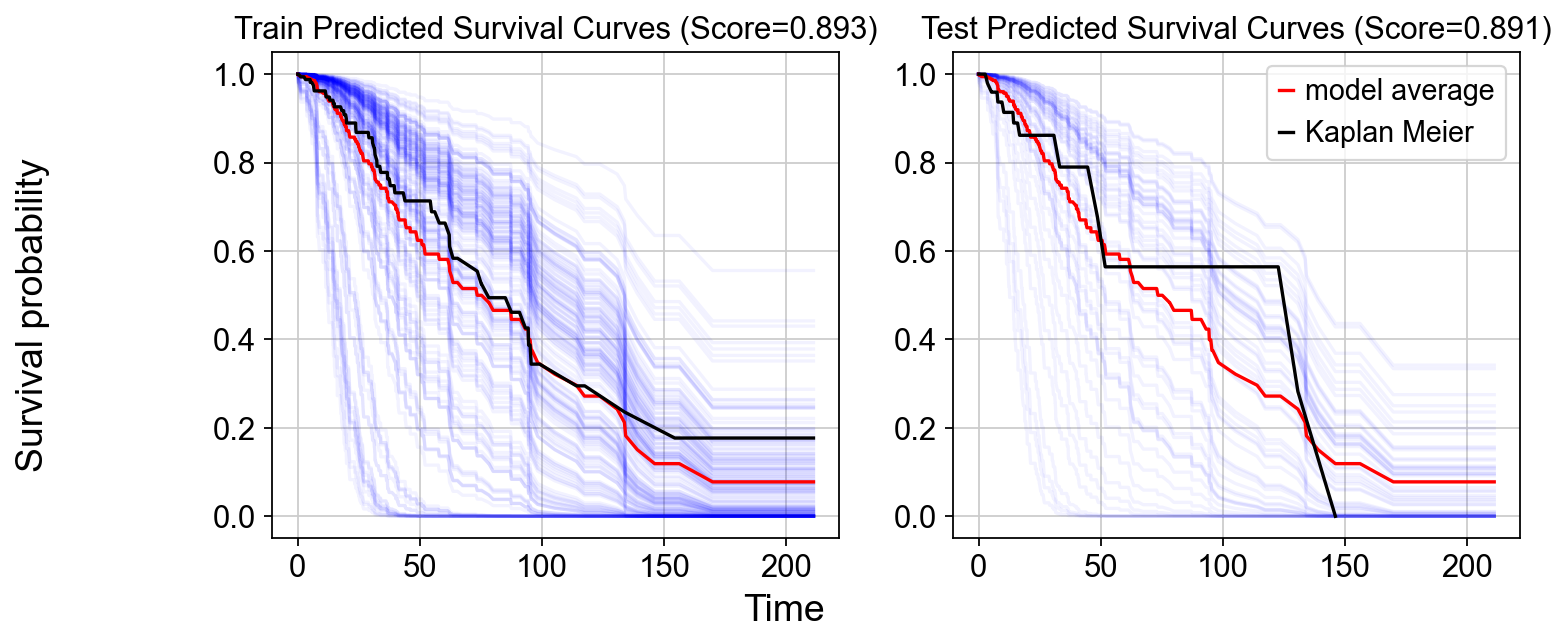

Curves for Sex: 1.0


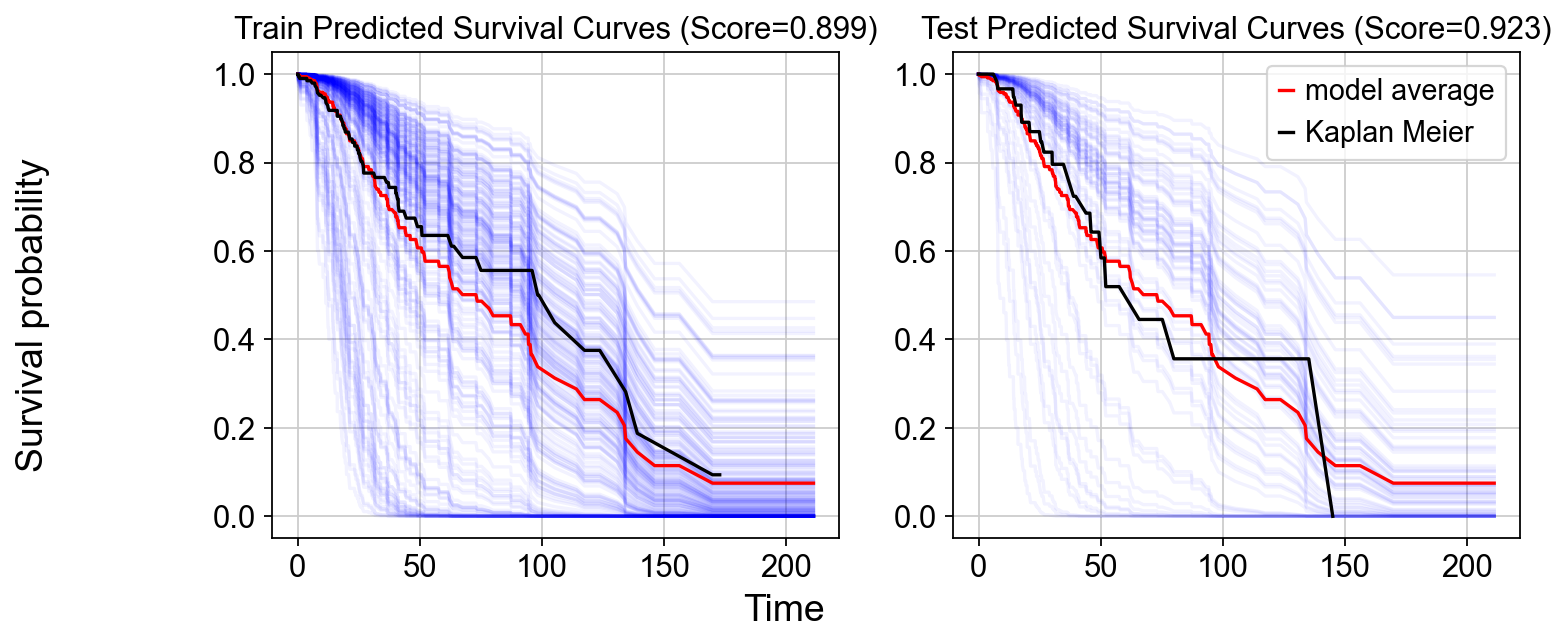

In [61]:
vars = ['Sex']
n = len(vars)

df = df_ML.copy()
for i in range(n):
    var = vars[i]
    for value in df[var].unique():
        mask = df[var] == value
        y_surv = pd.concat([df_ML['Overall Survival Status'][mask].astype(bool), 
                            df_ML['Overall Survival (Months)'][mask].apply(pd.to_numeric)],axis=1).to_records(index=False)

        X = df_ML[mask].drop(['Overall Survival Status', 'Overall Survival (Months)'], axis=1).reset_index(drop=True)
        X_surv=preproc(X)
        X_train, X_test, y_train, y_test = train_test_split(X_surv, y_surv, random_state=42)
        print(f'Curves for {var}: {value}')
        plot_surv_curves(X_train, y_train, X_test, y_test, cox_net)

  

## Automatic gene interpretation query

In [100]:
def get_gene_table(model, labels, k=12):
    # list of gene symbols
    features = list(plot_coef(model, labels, return_results=True, plot=False, k=k)[1])

    # extract numerical characters from each element
    symbol_list = [x[5:] for x in features if x.startswith('gene_')][::-1]
    
    desc = []
    symbols = []

    # email address to provide to NCBI
    Entrez.email = "your.email@example.com"
    # search for gene information for each symbol
    for symbol in symbol_list:
        try:
            gene = [k for k, v in id_to_symbol.items() if v == symbol][0]
            handle = Entrez.efetch(db="gene", id=str(gene), retmode='xml')
            record = Entrez.read(handle)
            handle.close()
            description = record[0]["Entrezgene_summary"]
        except:
            print(symbol)
            description = 'NA'
        # print gene symbol and description
        symbols.append(symbol)
        desc.append(description)

    return pd.DataFrame(list(zip(symbols, desc)), columns=['Symbol', 'Description'])

In [101]:
biodf = get_gene_table(cox_net,X.columns, k=15)

LINC00494


In [102]:
display(Markdown(biodf.to_markdown(index=False)))

| Symbol    | Description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
|:----------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| AGL       | This gene encodes the glycogen debrancher enzyme which is involved in glycogen degradation. This enzyme has two independent catalytic activities which occur at different sites on the protein: a 4-alpha-glucotransferase activity and a amylo-1,6-glucosidase activity. Mutations in this gene are associated with glycogen storage disease although a wide range of enzymatic and clinical variability occurs which may be due to tissue-specific alternative splicing. Alternatively spliced transcripts encoding different isoforms have been described. [provided by RefSeq, Jul 2008]                                                                                                                                                                                |
| GPS1      | This gene is known to suppress G-protein and mitogen-activated signal transduction in mammalian cells. The encoded protein shares significant similarity with Arabidopsis FUS6, which is a regulator of light-mediated signal transduction in plant cells. [provided by RefSeq, Mar 2016]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| WDHD1     | The protein encoded by this gene contains multiple N-terminal WD40 domains and a C-terminal high mobility group (HMG) box. WD40 domains are found in a variety of eukaryotic proteins and may function as adaptor/regulatory modules in signal transduction, pre-mRNA processing and cytoskeleton assembly. HMG boxes are found in many eukaryotic proteins involved in chromatin assembly, transcription and replication. Alternative splicing results in two transcript variants encoding different isoforms. [provided by RefSeq, Jul 2008]                                                                                                                                                                                                                              |
| BUD31     | Enables nuclear receptor binding activity and nuclear receptor coactivator activity. Involved in mRNA splicing, via spliceosome and positive regulation of androgen receptor activity. Located in nucleus. Part of U2-type catalytic step 2 spliceosome. Colocalizes with chromatin. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| LINC00494 | NA                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| ZNF83     | Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II cis-regulatory region sequence-specific DNA binding activity. Predicted to be involved in regulation of transcription by RNA polymerase II. Predicted to be located in nucleus. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                        |
| BRME1     | Predicted to be involved in meiosis I and spermatogenesis. Predicted to be located in chromosome. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| RCE1      | This gene encodes an integral membrane protein which is classified as a member of the metalloproteinase family.  This enzyme is thought to function in the maintenance and processing of CAAX-type prenylated proteins. [provided by RefSeq, Jul 2008]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| HES2      | Enables sequence-specific double-stranded DNA binding activity. Predicted to be involved in anterior/posterior pattern specification; regulation of neurogenesis; and regulation of transcription by RNA polymerase II. Predicted to be part of chromatin. Predicted to be active in nucleus. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                                                                                                                                                                                                                                                                                          |
| SRA1      | Both long non-coding and protein-coding RNAs are transcribed from this gene, and they represent alternatively spliced transcript variants. This gene was initially defined as a non-coding RNA, which is a coactivator for several nuclear receptors (NRs) and is associated with breast cancer. It has now been found that this gene is involved in the regulation of many NR and non-NR activities, including metabolism, adipogenesis and chromatin organization. The long non-coding RNA transcripts interact with a variety of proteins, including the protein encoded by this gene. The encoded protein acts as a transcriptional repressor by binding to the non-coding RNA. [provided by RefSeq, Mar 2012]                                                          |
| ENPP3     | The protein encoded by this gene belongs to a series of ectoenzymes that are involved in hydrolysis of extracellular nucleotides. These ectoenzymes possess ATPase and ATP pyrophosphatase activities and are type II transmembrane proteins. Expression of the related rat mRNA has been found in a subset of immature glial cells and in the alimentary tract. The corresponding rat protein has been detected in the pancreas, small intestine, colon, and liver. The human mRNA is expressed in glioma cells, prostate, and uterus. Expression of the human protein has been detected in uterus, basophils, and mast cells. Two transcript variants, one protein coding and the other non-protein coding, have been found for this gene. [provided by RefSeq, Oct 2015] |
| PLXNA4    | Predicted to enable semaphorin receptor activity. Predicted to be involved in several processes, including axon guidance; positive regulation of axonogenesis; and regulation of GTPase activity. Predicted to act upstream of or within several processes, including nervous system development; regulation of axon extension involved in axon guidance; and regulation of negative chemotaxis. Predicted to be located in plasma membrane. Predicted to be part of semaphorin receptor complex. Predicted to be integral component of plasma membrane. [provided by Alliance of Genome Resources, Apr 2022]                                                                                                                                                               |